In [363]:
import sys
sys.path.insert(0, '..')

In [364]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [365]:
#extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))


In [ ]:
wid = 64#128
oversample = 2

nwavels = 6
npoly=1

optics = NICMOSDistortedOptics(512, wid, oversample, distortion_orders=4)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    'n8yj53vfq_cal.fits'

]

ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits"]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    #"n43ca5fjq_cal.fits",
    #"n43ca5fkq_cal.fits",
    #"n43ca5flq_cal.fits",
    #"n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    #"n43ca5ffq_cal.fits",
    #"n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    #"n43c03dvq_cal.fits",
    #"n43c03dwq_cal.fits",
]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

Filename: ../data/MAST_2025-03-02T22_29_29.259Z/HST/n8ku01ffq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
extra bad


In [367]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()

print(files)


#exposures_single = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files][2:5]

['na2a12jmq_cal.fits', 'na2a12jnq_cal.fits', 'na2a12joq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jqq_cal.fits', 'na2a12jxq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k0q_cal.fits', 'na2a12k1q_cal.fits', 'na2a12k2q_cal.fits', 'na2a12k9q_cal.fits', 'na2a12kbq_cal.fits', 'na2a12kcq_cal.fits', 'na2a12kdq_cal.fits', 'na2a12keq_cal.fits', 'na2a12klq_cal.fits', 'na2a12knq_cal.fits', 'na2a12koq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kqq_cal.fits', 'na2a12kxq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l0q_cal.fits', 'na2a12l1q_cal.fits', 'na2a12l2q_cal.fits', 'na2a12lgq_cal.fits', 'na2a12liq_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lkq_cal.fits', 'na2a12llq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12luq_cal.fits', 'na2a12lvq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12lxq_cal.fits', 'na2a12m4q_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m7q_cal.fits', 'na2a12m8q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mgq_cal.fits', 'na2a12miq_cal.fits', 'na2a12mjq_cal.fits', 'na2a12mkq_cal.fits', 'na2a12mlq_cal.fits', 'na2a12ms

In [368]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "primary_distortion": {},
    "cold_mask_distortion": {},

    "softening": 0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

"""    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,"""

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    """params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([6., 6.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])"""
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

    params["primary_distortion"][exp.fit.get_key(exp, "primary_distortion")] = np.zeros((2,15))
    params["cold_mask_distortion"][exp.fit.get_key(exp, "cold_mask_distortion")] = np.zeros((2,15)).at[1,0].set(-0.1)#.at[1,0].set(0.06)#np.asarray([[0.0,0.0],[0.0,0.0]])

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [369]:
exp.fit.get_key(exp, "primary_distortion")

'F170M'

In [370]:
optics

NICMOSDistortedOptics(
  wf_npixels=512,
  diameter=2.4,
  layers={
    'CompoundAperture':
    CompoundAperture(
      normalise=True,
      transformation=CoordTransform(
        translation=None,
        rotation=f32[],
        compression=None,
        shear=None
      ),
      apertures={
        'main_aperture':
        HSTMainAperture(
          normalise=True,
          transformation=DistortedCoords(powers=f32[2,15], distortion=f32[2,15]),
          apertures={
            'mirror':
            CircularAperture(
              normalise=False,
              transformation=None,
              occulting=False,
              softness=2.0,
              radius=1.2
            ),
            'spider':
            Spider(
              normalise=False,
              transformation=None,
              occulting=True,
              softness=2.0,
              width=0.026399999999999996,
              angles=f32[4]
            ),
            'secondary':
            CircularAperture(
  

In [371]:
#plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

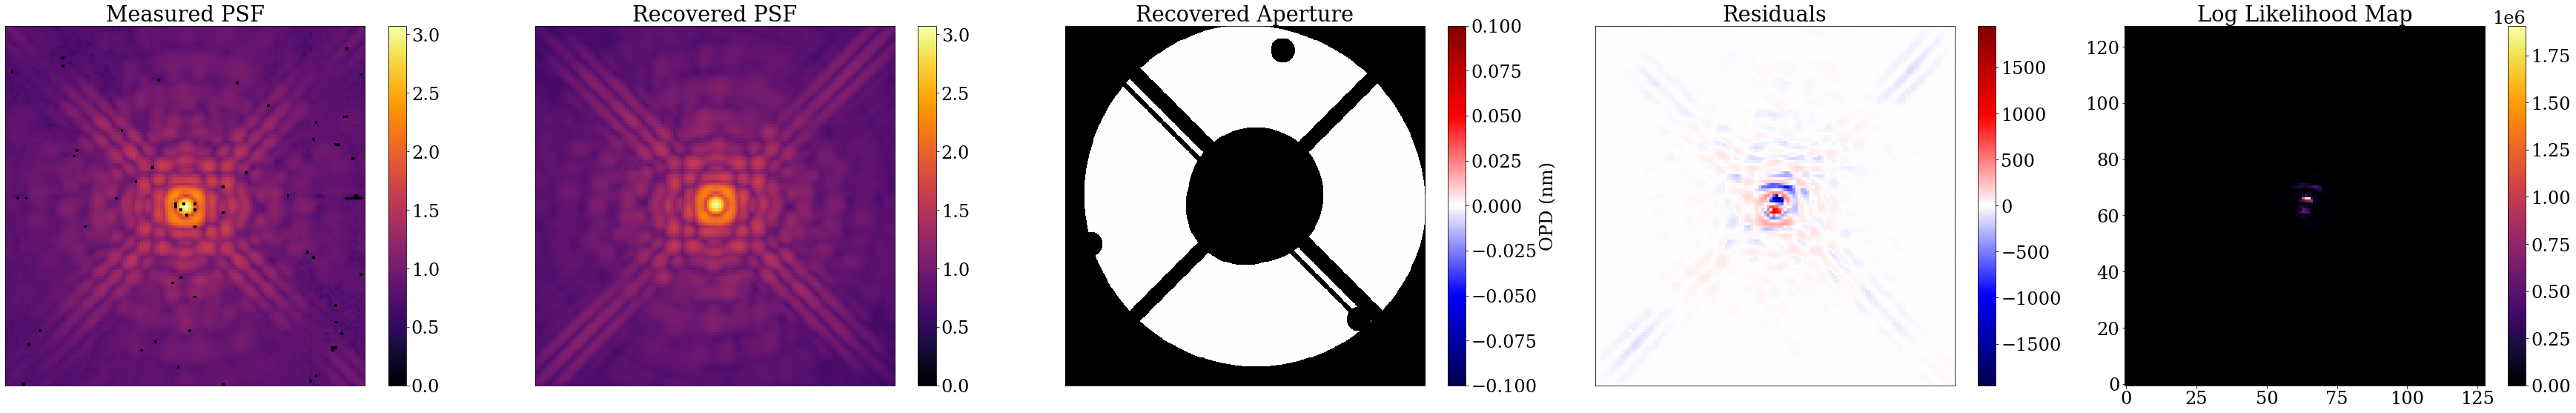

In [372]:
plot_comparison(model_single, params, exposures_single)

In [373]:
#stop

In [374]:
exposures_single[0].bad[35,60]

Array(False, dtype=bool)

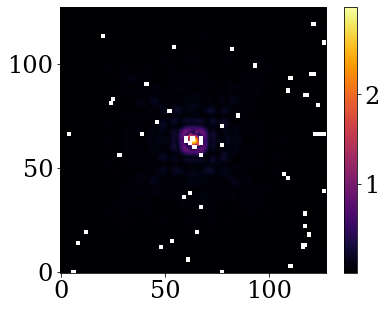

In [375]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

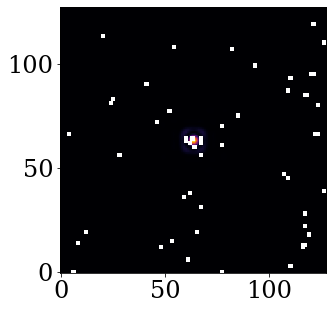

In [376]:
plt.imshow(exposures_single[0].data)

In [377]:
np.nanmin(exposures_single[0].err)

Array(0.01057486, dtype=float32)

In [378]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [379]:
loss_fn(params, exposures_single, model_single)

Array(26080906., dtype=float32)

In [380]:
#potat

In [381]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "positions": opt(g*50, 0),
    "spectrum": opt(g*80, 10),#, (20, 1.5)),
    #"cold_mask_shift": opt(g*50, 100),
    #"cold_mask_rot": opt(g*10, 50),
    "bias": opt(g*30, 20),
    "aberrations": opt(g*10,30),#, (80, 2)),#, (150, g*0.2)),
    "primary_distortion": opt(g*20, 80),
    "cold_mask_distortion": opt(g*20, 80),
    #"displacement": opt(g*30, 150),
}


groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [382]:
losses, models = optimise(params, model_single, exposures_single, things, 500)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'n8ku01ffq': {'positions': Array([[8.5512616e+07, 1.8939836e+07],
       [1.8939838e+07, 1.3819117e+08]], dtype=float32), 'spectrum': Array([[1.1973521e+09]], dtype=float32), 'bias': Array([[29535196.]], dtype=float32), 'aberrations': Array([[ 3.50663544e+02,  5.82867554e+02, -4.95229401e+02,
        -7.74784927e+01, -1.53823059e+02, -1.47861801e+02,
        -1.48846579e+01,  6.50254028e+02, -8.02763748e+01,
         3.49550690e+02,  3.99285278e+01,  3.47079124e+01,
        -4.39909821e+02, -3.76454376e+02, -2.81469696e+02,
         9.89911194e+01,  9.84050446e+01,  1.92292435e+02,
         2.56768280e+02, -2.15672699e+02,  8.06593094e+01,
        -1.00226345e+01,  1.42969589e+02,  1.59725967e+02,
        -7.54970016e+01,  2.80615692e+02],
       [ 5.82866394e+02, -3.54364128e+01, -9.81859894e+01,
        -3.47683868e+01, -8.28513870e+01, -1.45715055e+01,
         8.07241898e+01,  5.18713440e+02,  2.58194618e+01,
         7.28610413e+02,  3.63678703e+01,  7.90633621e+01,
        -2.08

  0%|          | 0/500 [00:00<?, ?it/s]

In [383]:
losses[-1]

Array(587890.7, dtype=float32)

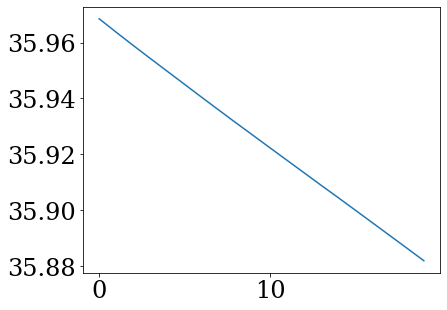

In [384]:
plt.plot(np.asarray(losses[-20:])/wid**2)

6


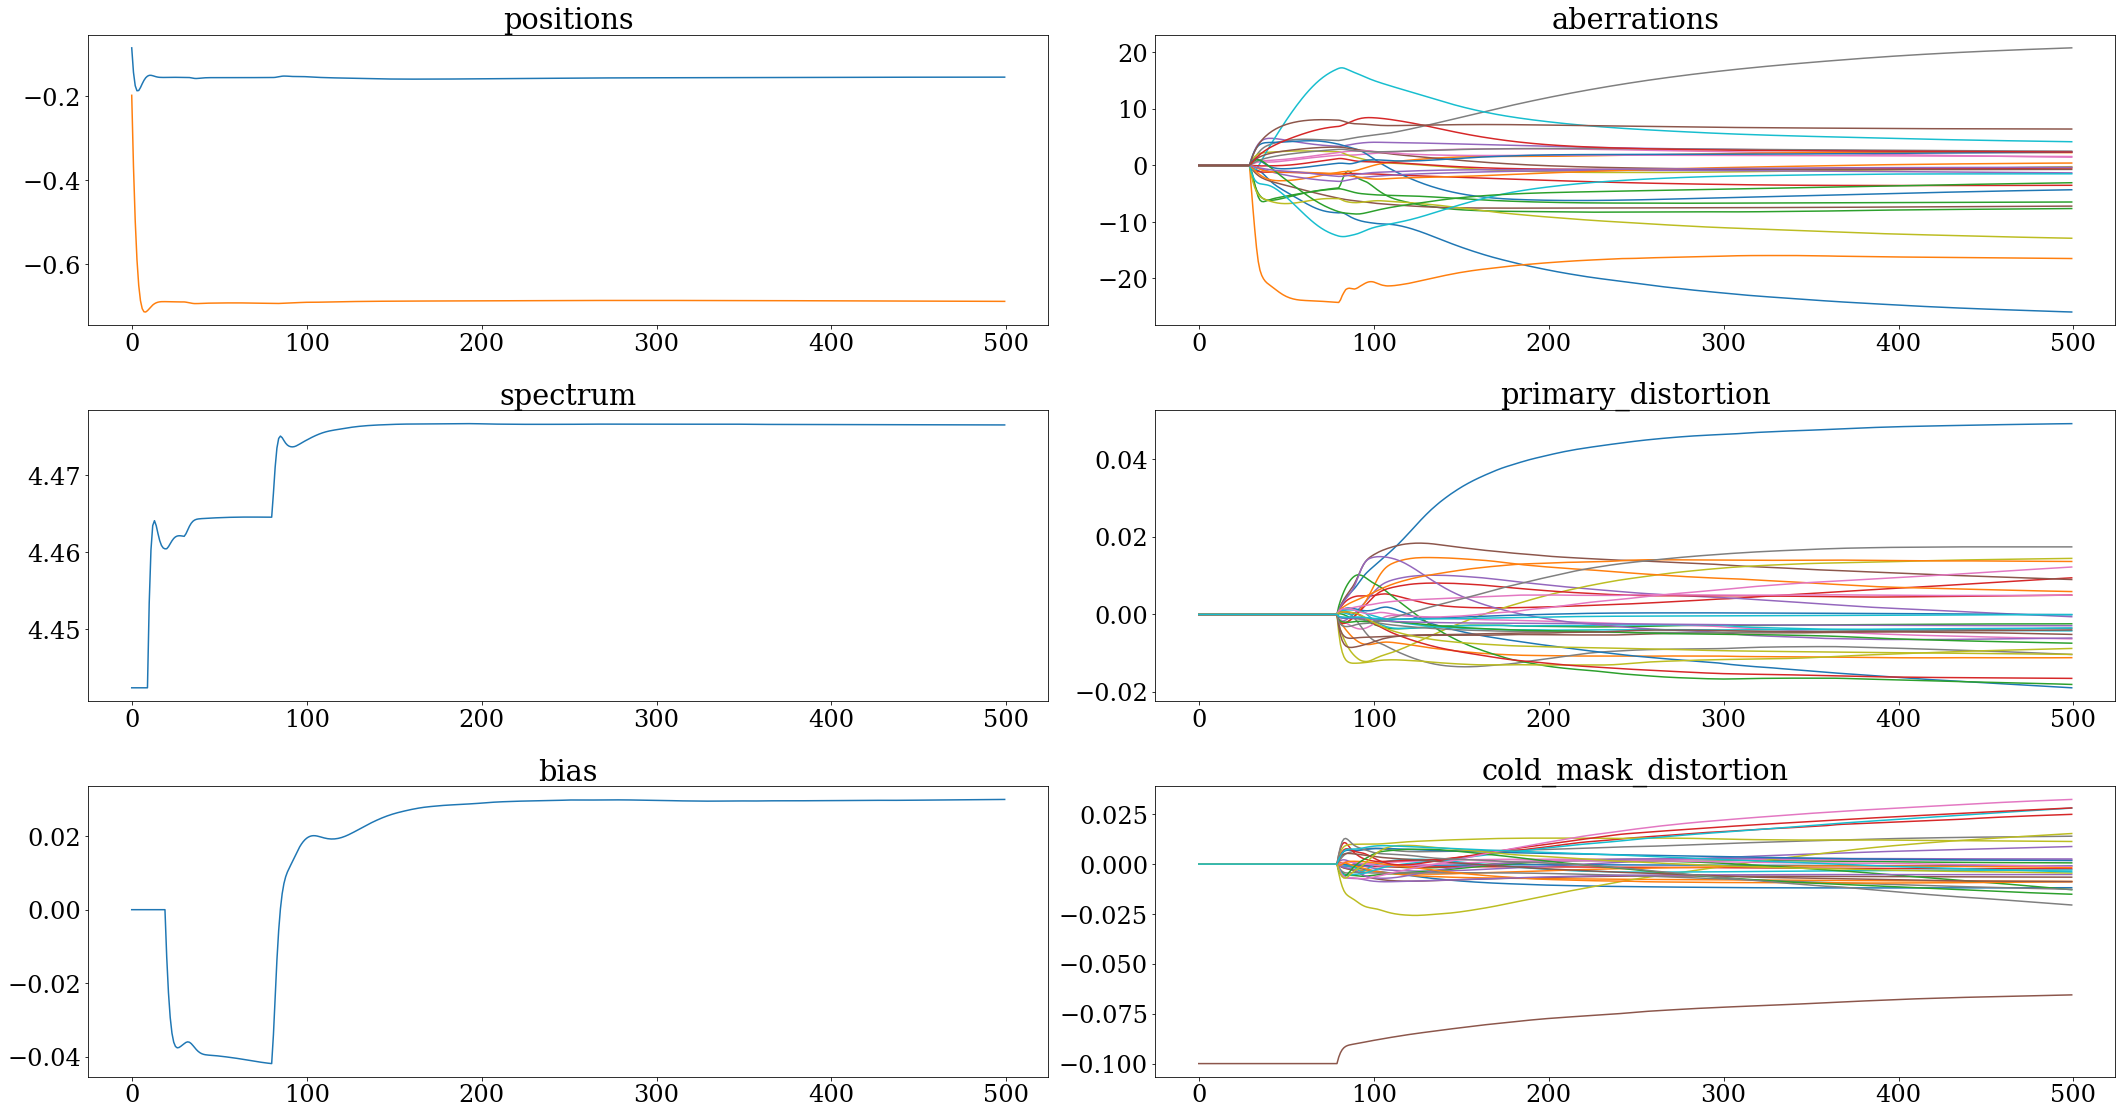

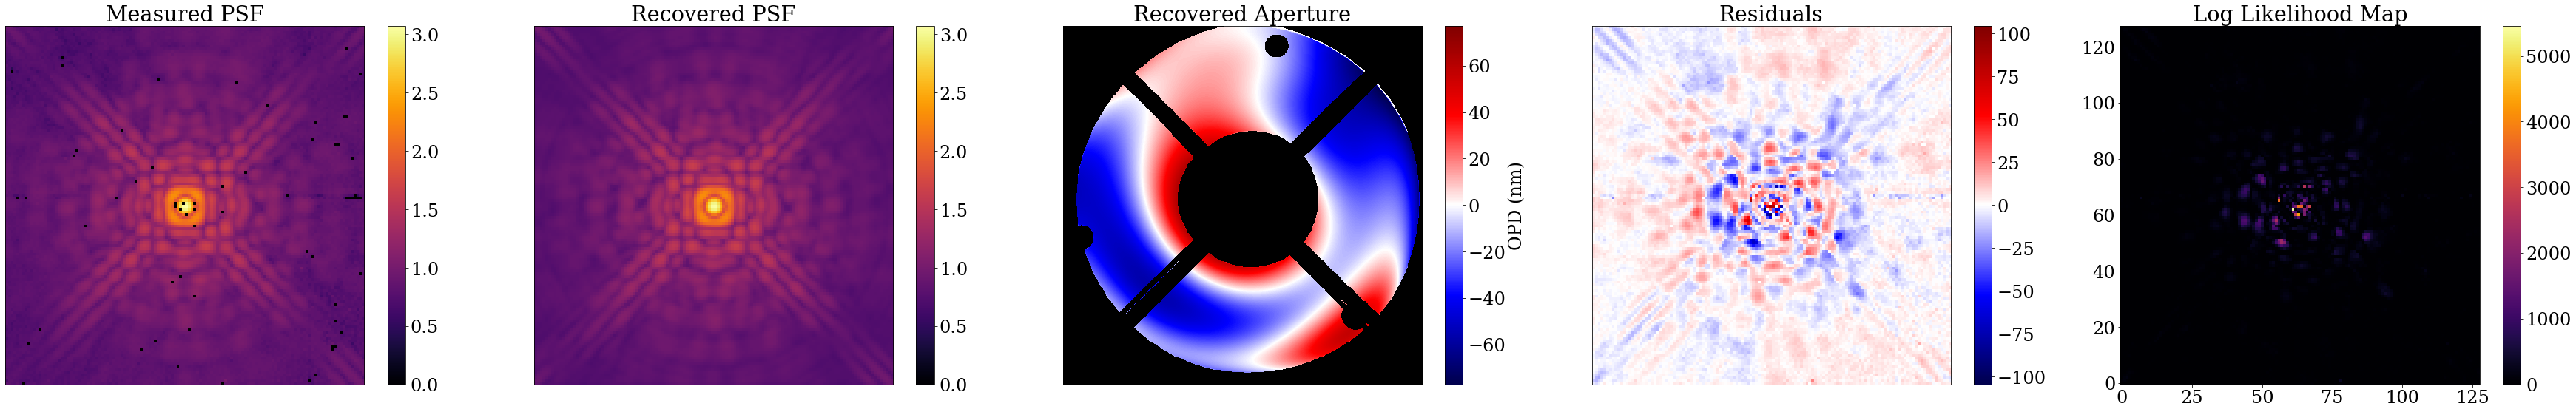

In [385]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [386]:
models[-1].params

{'aberrations': {'n8ku01ffq': Array([-25.926655  , -16.466436  ,  -7.626098  ,  -3.51123   ,
           2.4446783 ,  -7.1953473 ,   1.4650855 ,  20.802147  ,
          -0.21938449,   4.194093  ,  -4.302184  ,   2.2641392 ,
          -6.4688854 ,  -0.45951176,  -1.3142595 ,  -0.6987955 ,
           1.5766035 ,   2.5194921 , -12.880117  ,  -1.4771755 ,
           2.3342037 ,   0.42399922,  -3.0588024 ,   2.366232  ,
          -0.31846422,   6.4405394 ], dtype=float32)},
 'bias': {'n8ku01ffq': Array(0.0300032, dtype=float32)},
 'cold_mask_distortion': {'F170M': Array([[-0.01185592, -0.00869853,  0.00060241, -0.00238457,  0.00878568,
          -0.00656132,  0.0020469 ,  0.01396481,  0.0153014 , -0.00300316,
          -0.00083708, -0.00165064, -0.0128706 ,  0.02492061,  0.0025647 ],
         [-0.06556405, -0.00110006, -0.01265073,  0.01132361,  0.02806365,
           0.00177409, -0.00888485, -0.01511606,  0.02813468, -0.00522461,
          -0.00878069,  0.03239054, -0.02051235, -0.0045101 ,

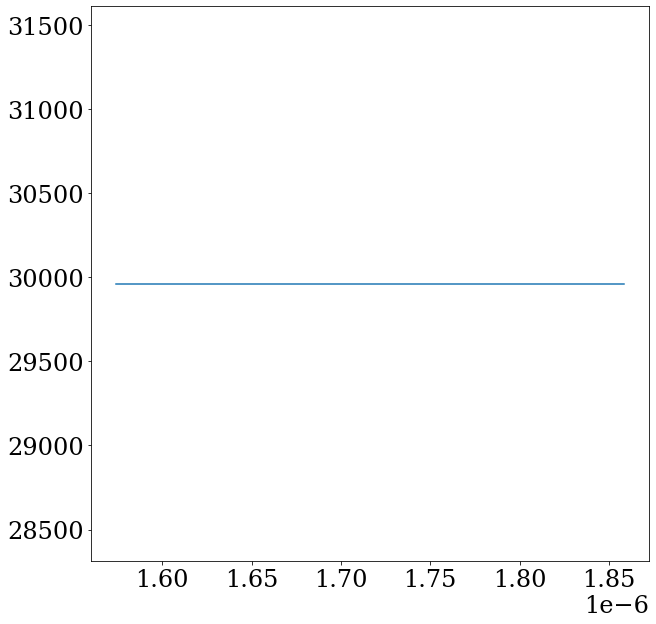

In [387]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F170M", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("spectrum.LHS1846_F170M")).weights))#), yerr = spectrum_err)


In [388]:
no

NameError: name 'no' is not defined

In [ ]:
bad = np.ones((wid, wid))

In [ ]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [ ]:
extra_bad = np.isnan(bad)

In [ ]:
idx

(Array(56, dtype=int32), Array(67, dtype=int32))

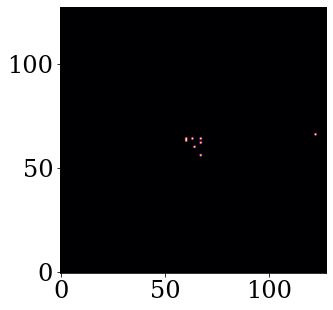

In [ ]:
plt.imshow(extra_bad)

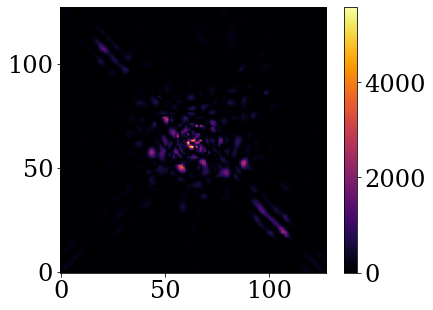

In [ ]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [ ]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)